<a href="https://colab.research.google.com/github/musicjae/NLP/blob/master/gpt2/gpt2_LM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import

In [2]:
import os

import numpy as np
import tensorflow as tf

!pip install mxnet
import mxnet

!pip install sentencepiece 
import sentencepiece

!pip install gluonnlp
!pip install transformers
import gluonnlp as nlp
from gluonnlp.data import SentencepieceTokenizer
from transformers import TFGPT2LMHeadModel

from tensorflow.keras.preprocessing.sequence import pad_sequences

from nltk.tokenize import sent_tokenize

import pandas as pd

     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 38.7MB 80kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1.2MB 10.3MB/s 
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 348kB 10.0MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595679 sha256=0bd30d04e0b7538a1fad519a78b947a7829c80ed9990a17ded604d01d17669f9
  Stored in directory: /root/.cache/pip/wheels/37/65/52/63032864a0f31a08b9a88569f803b5bafac8abd207fd7f7534
Successfully built gluonnlp
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2.0MB 10.7MB/s 
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚

In [3]:
!pip install wget
import wget
import zipfile

wget.download('https://github.com/NLP-kr/tensorflow-ml-nlp-tf2/releases/download/v1.0/gpt_ckpt.zip')

with zipfile.ZipFile('gpt_ckpt.zip') as z:
    z.extractall()

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=7aedec0a4addb7fa2164fca8aa623c4c48a47987f9515b77308011137e7aa8df
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


# Model

In [4]:
class GPT2Model(tf.keras.Model):
    def __init__(self, dir_path):
        super(GPT2Model, self).__init__()
        self.gpt2 = TFGPT2LMHeadModel.from_pretrained(dir_path)
        
    def call(self, inputs):
        return self.gpt2(inputs)[0]

In [5]:
BASE_MODEL_PATH = './gpt_ckpt'
gpt_model = GPT2Model(BASE_MODEL_PATH)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at ./gpt_ckpt.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [11]:
BATCH_SIZE = 2
NUM_EPOCHS = 10
MAX_LEN = 600
TOKENIZER_PATH = './gpt_ckpt/gpt2_kor_tokenizer.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                               mask_token=None,
                                               sep_token=None,
                                               cls_token=None,
                                               unknown_token='<unk>',
                                               padding_token='<pad>',
                                               bos_token='<s>',
                                               eos_token='</s>')

In [48]:
def tf_top_k_top_p_filtering(logits, top_k=0, top_p=0.0, filter_value=-99999):
    _logits = logits.numpy()
    top_k = min(top_k, logits.shape[-1])  
    if top_k > 0:
        indices_to_remove = logits < tf.math.top_k(logits, top_k)[0][..., -1, None]
        _logits[indices_to_remove] = filter_value

    if top_p > 0.0:
        sorted_logits = tf.sort(logits, direction='DESCENDING')
        sorted_indices = tf.argsort(logits, direction='DESCENDING')
        cumulative_probs = tf.math.cumsum(tf.nn.softmax(sorted_logits, axis=-1), axis=-1)

        sorted_indices_to_remove = cumulative_probs > top_p
        sorted_indices_to_remove = tf.concat([[False], sorted_indices_to_remove[..., :-1]], axis=0)
        indices_to_remove = sorted_indices[sorted_indices_to_remove].numpy().tolist()
        
        _logits[indices_to_remove] = filter_value
    return tf.constant([_logits])


def generate_sent(seed_word, model, max_step=256, greedy=False, top_k=0, top_p=0.):
    sent = seed_word
    toked = tokenizer(sent)
    
    for _ in range(max_step):
        input_ids = tf.constant([vocab[vocab.bos_token],]  + vocab[toked])[None, :] 
        outputs = model(input_ids)[:, -1, :]
        if greedy:
            gen = vocab.to_tokens(tf.argmax(outputs, axis=-1).numpy().tolist()[0])
        else:
            output_logit = tf_top_k_top_p_filtering(outputs[0], top_k=top_k, top_p=top_p)
            gen = vocab.to_tokens(tf.random.categorical(output_logit, 1).numpy().tolist()[0])[0]
        if gen == '</s>':
            break
        sent += gen.replace('‚ñÅ', ' ')
        toked = tokenizer(sent)

    return sent

In [13]:
generate_sent('Í≥†ÏñëÏù¥Îûë ÏßëÏùÑ', gpt_model, greedy=True)

'Í≥†ÏñëÏù¥Îûë ÏßëÏùÑ ÏòÆÍ≤ºÎäîÎç∞'

In [14]:
generate_sent('Í≥†ÏñëÏù¥Îûë ÏßëÏùÑ', gpt_model, top_k=0, top_p=0.95)

'Í≥†ÏñëÏù¥Îûë ÏßëÏùÑ ÏòÆÍ≤ºÎäîÎç∞ Í∑∏Ï™Ω ÏïÑÏù¥ÎøåÍ≤ÉÏù∏ Í≥ÑÎ¶ºÏù¥Í∞Ä  ÎÇ¥Í∞Ä  Ïò®Îã§'

In [49]:
dir='/content/drive/MyDrive/Colab_Notebooks/JJY/·Ñã·Öµ·ÜØ·ÑÄ·Öµ ·Ñâ·Ö¢·Üº·Ñâ·Ö•·Üº/dataset/diary/20210305_blog_daily.tsv'
df = pd.read_csv(dir,sep='\t')
import re

def cleansing(df):
    for i,sen in enumerate(df.contents):
        sen = sen.replace('#Îã§Ïù¥Ïñ¥Ìä∏ #Îã§Ïù¥Ïñ¥ÌÑ∞ #Ïú†ÏßÄÏñ¥ÌÑ∞ #Îã§Ïù¥Ïñ¥Ìä∏ÏùºÍ∏∞ #ÏãùÎã®ÏùºÍ∏∞ #Ï≤¥Ï§ëÍ∏∞Î°ù #Ïú°ÏïÑÏùºÍ∏∞ #Ïú°ÏïÑÏùºÏÉÅ #ÏöòÎë•Ïù¥ÏùòÌïòÎ£®','')
        sen = sen.replace('üß∏','')
        sen = sen.replace('‚ú®','')
        sen = sen.replace('Ïù¥Ïò§Îãà ÏÉùÌõÑ','')
        sen = sen.replace('#','')
        sen = sen.replace('Ïú°ÏïÑÏùºÍ∏∞ Í∏∞Î°ùÏùÄ','')
        sen = sen.replace('üíõ','')
        sen = sen.replace('üíñ','')

        df.contents[i] = sen

    return df

data = cleansing(df).contents
sents = [s[:-1] for s in data]
sents

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


['   277Ïùº   276ÏùºÏûòÏûîÎìØ ÏûòÎ™ªÏûî Í∑∏Îü∞ ÌïòÎ£® Í∑∏ÎûòÎèÑ Ïò§ÎûúÎßåÏóê Ïπ®ÎåÄÏóêÏÑú ÏûîÍ≤å Î≠êÎùºÍµ¨ Ïù¥Î†áÍ≤å Î™∏Ïù¥ Í∞ÄÎ≤ºÏö¥ Í∏∞Î∂Ñ(?)Ïù∏ÏßÄ Î™®Î•¥Í≤åÎî∞ (Ï†ïÎßê Í∏∞Î∂ÑÎßå Í∞ÄÎ≤ºÏõÄ Îî∞Ìùë)ÏïÑÏπ®Î∂ÄÌÑ∞ ÏÇ¨Í≥†Ïπ† Ï§ÄÎπÑ ÌïòÎäî Ïù¥Ïò§Îãà ÏïÑÏ°∞Í∑∏ÎÉ• Ïó≠Î∞©Ïø† Î∞üÍ≥† Ïò¨ÎùºÍ∞ÄÏÑú ÍπåÏπòÎ∞úÍπåÏßÄ Îì§Í≥† ÍººÏßÄÎùΩ ÍººÏßÄÎùΩÎ¶¨Î™®Ïª® ÎìùÌÖú! ÏïÑÎãà Í∑∏Í≤å Í±∞Í∏∞ ÏûàÎäîÍ≤å Î≥¥Ïó¨? Ïñ¥ÎñªÍ≤å ÏïÑÎäîÍ±∞Ïïº? ÎÉÑÏÉàÎ°ú ÏïÑÎÇò? Ïã∂ÏùÑ Ï†ïÎèÑÎ°ú Ïûò Ï∞æÏïÑÎÇ¥Îäî Í≤ÉÌåÖÌåÖ Î∂ÄÏñ¥Í∞ÄÏßÄÍ≥† „Öã„Öã„Öã„Öã„Öã„Öã„Öã„Öã„Öã„Öã„Öã„Öã„Öã„Öã Î®∏Î¶¨Îäî ÍπåÏπòÏßëÏùÑÌï¥ÏÑúÎäî Í∑∏Î†áÍ≤å Ï≥êÎã§Î≥¥Î©¥ Í∑∏Îûò.. Ïû†Íπê Í∞ÄÏßÄÍ≥† ÎÜÄÏïÑÎ∞îÎùº.. ÌïòÍ≤†ÏßÄ Î™®ÏöîÎÜà Ï•êÏ•êÎ∞©Íµ¨ ÎÇ¥ Î®∏Î¶¨ÏúÑÏóê ÏûàÎäîÍ≤å Î∂ÑÎ™ÖÌï¥Îã§Îçú ÏãúÏÑúÏä§ÏãúÏÑúÏä§ ÌïòÍ∏∏Îûò Î®∏ÏÑ† Î∏åÎûúÎìúÏù∏Ï§Ñ ÏïåÏïòÎäîÎç∞ Îã§Ïù¥Ïñ¥Ìä∏ Î≥¥Ï°∞Ï†ú ÏõêÎ£å? Í∑∏Îü∞Í±¥Í∞ÄÎ∂ÄÎã§ ÌõÑ, ÎßåÎÖÑÎã§Ïù¥Ïñ¥ÌÑ∞ ÎùºÍ≥† ÌïòÎ©¥ÏÑú Ïù¥Ï†ú Ïù¥Îü∞Í≤ÉÎèÑ Î™®Î•¥Í≥† ÎßêÏïº ÌÉÄÏù¥ÌãÄ ÎÇ¥Î†§ÎÜîÏïºÍ≤êÎÑ§ÏúºÏïÖ! Ïù¥Î†áÍ≤å ÏûëÎã§Îãà! ÏÑ∏ÏÉÅÏóê! Ïù¥Îü∞Í±∏ Î≥¥Í≥† ÏûêÍæ∏ Ïã†ÏÉùÏïÑÎï

In [39]:
input_data = []
output_data = []

for s in sents:
    tokens = [vocab[vocab.bos_token],]  + vocab[tokenizer(s)] + [vocab[vocab.eos_token],]
    input_data.append(tokens[:-1])
    output_data.append(tokens[1:])

input_data = pad_sequences(input_data, MAX_LEN, value=vocab[vocab.padding_token])
output_data = pad_sequences(output_data, MAX_LEN, value=vocab[vocab.padding_token])

input_data = np.array(input_data, dtype=np.int64)
output_data = np.array(output_data, dtype=np.int64)

In [40]:

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, vocab[vocab.padding_token]))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

def accuracy_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, vocab[vocab.padding_token]))
    mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
    pred *= mask    
    acc = train_accuracy(real, pred)

    return tf.reduce_mean(acc)

In [41]:
gpt_model.compile(loss=loss_function,
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=[accuracy_function])

In [42]:
history = gpt_model.fit(input_data, output_data, 
                    batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=0.1)

Epoch 1/10
68/68 [==============================] - 75s 846ms/step - loss: 3.9303 - accuracy_function: 0.3167 - val_loss: 2.9806 - val_accuracy_function: 0.3678
Epoch 2/10
68/68 [==============================] - 55s 803ms/step - loss: 2.9615 - accuracy_function: 0.3796 - val_loss: 2.5752 - val_accuracy_function: 0.4004
Epoch 3/10
68/68 [==============================] - 55s 804ms/step - loss: 2.6623 - accuracy_function: 0.4081 - val_loss: 2.3241 - val_accuracy_function: 0.4234
Epoch 4/10
68/68 [==============================] - 55s 804ms/step - loss: 2.4421 - accuracy_function: 0.4295 - val_loss: 2.0603 - val_accuracy_function: 0.4423
Epoch 5/10
68/68 [==============================] - 55s 804ms/step - loss: 2.2938 - accuracy_function: 0.4473 - val_loss: 1.8373 - val_accuracy_function: 0.4595
Epoch 6/10
68/68 [==============================] - 55s 804ms/step - loss: 2.0812 - accuracy_function: 0.4646 - val_loss: 1.6407 - val_accuracy_function: 0.4756
Epoch 7/10
68/68 [================

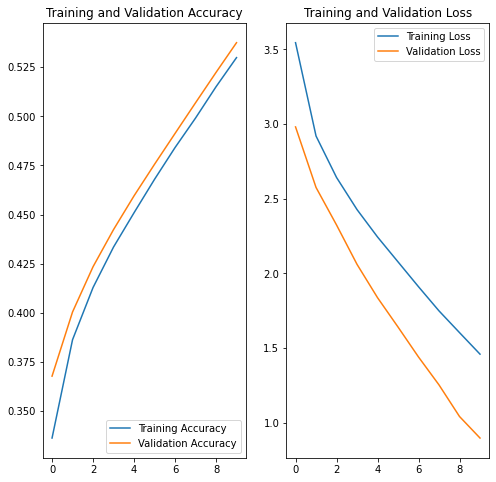

In [44]:
import matplotlib.pyplot as plt

acc = history.history['accuracy_function']
val_acc = history.history['val_accuracy_function']

loss= history.history['loss']
val_loss= history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [45]:
DATA_OUT_PATH = '/content/drive/MyDrive/Colab_Notebooks/JJY/·Ñã·Öµ·ÜØ·ÑÄ·Öµ ·Ñâ·Ö¢·Üº·Ñâ·Ö•·Üº/gpt2/gpt_v2'
model_name = "tf2_gpt2_finetuned_model"

save_path = os.path.join(DATA_OUT_PATH, model_name)

if not os.path.exists(save_path):
    os.makedirs(save_path)

gpt_model.gpt2.save_pretrained(save_path)

loaded_gpt_model = GPT2Model(save_path)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at /content/drive/MyDrive/Colab_Notebooks/JJY/·Ñã·Öµ·ÜØ·ÑÄ·Öµ ·Ñâ·Ö¢·Üº·Ñâ·Ö•·Üº/gpt2/gpt_v2/tf2_gpt2_finetuned_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [54]:
for _ in range(2):
     print(generate_sent('ÏÇ∞Ï±Ö', gpt_model, top_k=7, top_p=0.9))

ÏÇ∞Ï±ÖÎèÑ                                                                                                                                                                                                                                                               
ÏÇ∞Ï±ÖÌï† Îïå ÎèÑ     Ïû•ÎÇúÍ∞ê ÏùÄÍ∑º                                                                                                                                                                                                                                                


### References  
[1]  https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf  

[2] https://github.com/NLP-kr/tensorflow-ml-nlp-tf2/blob/master/7.PRETRAIN_METHOD/7.4.2.gpt2_finetune_NSMC.ipynb